# Merging CRSP and Compustat Data (Python)
This notebook provides a guide to merging data from the CRSP and Compustat datasets at the securities level using Python. It replicates the [SAS version](https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/) from [Wharton Research Data Services](https://wrds-www.wharton.upenn.edu/).

## Background
CRSP and Compustat have been two of the most widely-used datasets in empirical finance and accounting literature since the early 1990s. Between 2001 and 2015, the combined Web queries for these two datasets together account for more than 80% of WRDS website traffic. This notebook provides a general guide to matching and merging data from these two databases at the securities level.

## Changing Security Identifiers
Among all commonly-used security/company identifiers, TICKER and CUSIP are probably the most frequently cited. TICKER is the abbreviation used to uniquely identify publicly-traded shares of a particular stock, while CUSIP is the nine-character alphanumeric code assigned by the CUSIP Service Bureau to identify various securities.

However, there are a few problems associated with those two identifiers for researchers looking to use them to match historical records. First of all, neither identifier is permanent. A change in CUSIP, for example, could be triggered by any change in the security, including non-fundamental events such as splits and company name changes. In addition, retired stock TICKER symbols are often reused.

The following table shows an example where both the TICKER and CUSIP were changed three times in roughly four years, and the name of the company changed once.

![Table](https://wrds-www.wharton.upenn.edu/media/images/ccm_figure_1.width-800.png)

Because TICKERs and CUSIPs change over time, most datasets use permanent identifiers to indicate the same securities and companies. For example, CRSP employs PERMNO to track stocks, Compustat uses GVKEY to follow companies, and a combination of GVKEY and IID is used to track securities. As indicated in the preceding table, both PERMNO and GVKEY (+IID) remain the same, regardless of changes in TICKER, CUSIP, and company names. One thing worth noticing is that, unlike CRSP, Compustat does not keep historical records in their standard datafeed.

## CRSP vs. Compustat Data Structure

To understand how data is matched, keep in mind the structural differences between the two datasets. The following table demonstrates four major structural differences between CRSP and Compustat data:

|     |	CRSP |	Compustat North American |
|:-----|:------|:---------------------------|
|Time | From 1925[1] |	From 1950
|Universe | Firms listed in U.S. major <br> exchanges: NYSE, NASDAQ,<br> AMEX, and ARCA | U.S. (10Q filers) and Canadian firms:<br> - listed in major U.S. or Canadian exchanges<br> - listed in regional exchanges<br> - with shares traded as OTC, or<br> - with a certain amount of public bonds|
|Frequency	| Daily or Monthly	| Quarterly and Annually |
|Inclusion |	Securities are included from<br> their IPO |	Traditionally, Compustat only includes a firm after it<br> has publicly disclosed its financial statements for a<br> few years. [2] |

[1] In fact, CRSP includes stocks listed in different exchanges over different periods of time. In particular, CRSP includes stocks listed on the NYSE, NYSE MKT (AMEX), NASDAQ, and ARCA from 1925, 1962, 1972, and 2006, respectively.

[2] Early researchers (for example, Kothari, Shanken and Sloan (1995)), find a selection bias (survivorship bias) in the way in which firms are added to the Compustat database. In particular, Compustat adds a new firm into its system only when the firm has reported its financial statement for multiple years, which is sometimes called back-filling bias.

These structural differences typically create three kinds of unmatchable scenarios:

* Prior to 1950, trading records (CRSP) cannot be matched to fundamental items (Compustat).
* Fundamental items cannot be matched to trading records when firms are listed in regional exchanges, are traded as OTC, or only have bonds publicly traded.
* Trading records cannot be matched to fundamental items when those stocks did not survive long enough (e.g., due to M&A) for Compustat to include their fundamental items.

## Data-Matching Implementation
### Merge by CUSIP
Starting in 1968, the CUSIP Service Bureau began assigning the CUSIP - a nine-character alphanumeric identifier - to a publicly traded security. Unlike TICKER, CUSIP is not a reusable security identifier, so it has been widely used to match different data from different datasets. CRSP and Compustat, however, use slightly different approaches to keeping CUSIP records. CRSP drops the 9th (checksum) digit in CUSIPs and keeps historical CUSIPs, while Compustat uses the full, 9-digit CUSIP and keeps only the most current CUSIP.[3]

The following Python code sample shows matching CRSP and Compustat data at the security level by CUSIP:

In [1]:
import wrds
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz

###################
# Connect to WRDS #
###################
conn = wrds.Connection()

conn.describe_table(library="crsp", table="msf")
conn.describe_table(library="crsp", table="msenames")
conn.describe_table(library="comp", table="security")

###########################
# Method 1: Link by CUSIP #
###########################

# # 1.1 CRSP MSF: Get the list of PERMNO, DATE in CRSP Monthly Stock File
# crsp_msf = conn.raw_sql("""
#                         select distinct permno, date,
#                                        cusip
#                         from crsp.msf
#                         """)

# # 1.2 CRSP MSENAMES: Get the list of PERMNO, NCUSIP, NAMEDT, NAMEENDT in CRSP Monthly Stock Event - Name History
# crsp_msenames = conn.raw_sql("""
#                              select distinct permno, ncusip, namedt, nameendt,
#                                              cusip, ticker, comnam
#                              from crsp.msenames
#                              where ncusip != ''
#                              and shrcd in (10,11)
#                              """)

# # 1.3 COMPUSTAT SECURITY: Get the list of GVKEY, IID in COMPUSTAT SECURITY
# comp = conn.raw_sql("""
#                     select distinct gvkey, iid, cusip,
#                                     tic
#                     from comp.security
#                     where cusip != ''
#                     and excntry='USA'
#                     """)

# # 1.4 Merge CRSP MSF and MSENAMES and keep relevant dates
# crsp_m = crsp_msf.merge(crsp_msenames, on='permno')
# crsp_m = crsp_m[(crsp_m.namedt <= crsp_m.date) & (crsp_m.date <= crsp_m.nameendt)]

# # 1.5 Merge CRSP and COMPUSTAT by 8-digit cusip
# # Compustat also provides historical CUSIP and TICKER in its Snapshot product,
# # although historical identifiers are not available in their standard
# # fundamental data feed.
# comp['cusip8'] = comp.cusip.str[0:8]
# link = comp.merge(crsp_m, left_on='cusip8', right_on='ncusip')
# link = link[['permno', 'gvkey', 'date']]
# link = link.sort_values(['permno', 'gvkey', 'date'])
# link = link.reset_index(drop=True)

# 1.1 - 1.5 all-in-one from SQL
cusip_link = conn.raw_sql("""
                          select distinct a.permno, gvkey, date
                          from
                          crsp.msf as a,
                          crsp.msenames as b,
                          comp.security as c
                          where
                          b.ncusip != '' and shrcd in (10,11)
                          and c.cusip != '' and excntry='USA'
                          and a.permno = b.permno
                          and NAMEDT <= date and date <= NAMEENDT
                          and b.ncusip = substr(c.cusip,1,8)
                          """)
cusip_link = cusip_link.sort_values(['permno', 'gvkey', 'date'])
cusip_link = cusip_link.reset_index(drop=True)

# # Check if the merge method and sql all in one method equivalent:
# cusip_link.equals(link) # Expect True

/Users/shinggg/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading library list...
Done
Approximately 4509850 rows in crsp.msf.
Approximately 99086 rows in crsp.msenames.
Approximately 61282 rows in comp.security.


True

[3] Compustat also provides historical CUSIP and TICKER in its Snapshot product, although historical identifiers are not available in their standard fundamental data feed.

There are three major limitations to matching CRSP and Compustat data by CUSIP:

1. Prior to 1968, CUSIP did not exist, so using CUSIP to match data is only reliable from 1968 onwards.
2. CRSP only keeps historical CUSIP data when the securities are traded in major exchanges. If the most recent CUSIP in Compustat is from a regional or OTC market, CRSP and Compustat records will not match properly.
3. CRSP and Compustat refresh their data with different frequencies. The most recent CUSIP in one database may not be synchronized with the most recent CUSIP in the other, which may, in turn, lead to mismatched data.

### Merge by CCM Link table<br>

<div class="rich-text">
    <p>The CRSP/Compustat Merged Database (CCM) is comprised of CRSP and Compustat data, together with the link and link-history references between these two databases. The key product of CCM is a permanent identifier linking table (PERMNO to GVKEY+IID), though CCM is often wrongly mistaken as the merged product of CRSP stock market data with Compustat accounting data. From an end user’s perspective, CCM only adds a link of PERMNO and PERMCO to the Compustat database, so that Compustat items can be searched by CRSP identifiers.</p><p>In the link table (Ccmxpf_linktable), there are a few indicators of the quality of matching:</p><p><strong>LinkType:</strong> A code describing the connection between the CRSP and Compustat data.</p><ul><li><strong>LU:</strong> Link research complete. Standard connection between databases.</li><li><strong>LC:</strong> Non-researched link to issue by CUSIP.</li><li><strong>LD:</strong> Duplicate link to a security. Another GVKEY/IID is a better link to that CRSP record.</li></ul><p><strong>LinkPrim:</strong> Primary issue indicator for the link.</p><ul><li><strong>P:</strong> Primary, identified by Compustat in monthly security data.</li><li><strong>C</strong>: Primary, assigned by CRSP to resolve ranges of overlapping or missing primary markers from Compustat in order to produce one primary security throughout the company history.</li></ul><p><strong>UsedFlag:</strong> Flag marking whether the link is used in creating the composite record.</p><ul><li><strong>1:</strong> The link is applicable to the selected PERMNO and used to identify ranges of Compustat data from a GVKEY used to create a composite GVKEY record corresponding to the PERMNO.</li><li><strong>-1:</strong> The link is informational, indirectly related to the PERMNO, and not used.</li><li><strong>USEDFLAG:</strong> Legacy indicator kept for programing and data consistency at WRDS.</li></ul><p><strong>LINKDT:</strong> The first effective date of the link.<br><strong>LINKENDDT:</strong> The last date when the link is valid. For a currently valid link, LINKENDDT is set to a NULL value (.E in SAS format).</p><p></p><p>The following sample Python code is used for matching CRSP and Compustat at the security level using the CCM Linktable:</p><p></p>
</div>

In [2]:
####################################
# Method 2: Link by CCM Link Table #
####################################

# 2.1 all-in-one from SQL
ccm_link = conn.raw_sql("""
                        select distinct a.permno, gvkey, date
                        from
                        crsp.msf as a,
                        crsp.msenames as b,
                        crsp.Ccmxpf_linktable as c
                        where
                        shrcd in (10,11)
                        and linktype in ('LU','LC')
                        and LINKPRIM in ('P','C')
                        and USEDFLAG=1
                        and a.permno = b.permno and b.permno = lpermno
                        and NAMEDT <= date and date <= NAMEENDT
                        and linkdt <= date and date <= coalesce(linkenddt, current_date)
                        """)

The following graph shows the number of companies for a stock-level match used by the CCM Link table as well as a match by CUSIP from 1950 to 2014. Only stocks having CRSP share code 10 or 11 and companies having non-missing Asset or Sales Items from Compustat were used in this match. Due to the matching limitations using CUSIP as previously described, CCM always provides greater numbers of matched results, with the two results converging in more recent years.

Sample Python code (for use in a Jupyter Notebook) is provided above the graph.

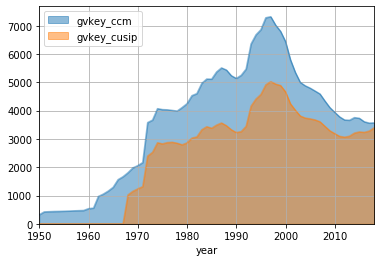

In [3]:
##################################
# Compare Method 1 and 2 #
##################################

# Get Companies with non-missing Asset or Sales Item
funda = conn.raw_sql("""
                     select distinct gvkey, datadate,
                     sale, at
                     from
                     comp.funda
                     where
                     sale > 0 or at > 0
                     """)

funda = funda.sort_values(['gvkey', 'datadate']).reset_index(drop=True)

# Create 'year' variables from dates
funda['year'] = pd.to_datetime(funda.datadate).dt.year
ccm_link['year'] = pd.to_datetime(ccm_link.date).dt.year
cusip_link['year'] = pd.to_datetime(cusip_link.date).dt.year

# Use CCM LINK to Match on Calendar Year Base
ccm_l1 = pd.merge(ccm_link, funda, on=['gvkey', 'year'])
ccm_l2 = pd.merge(ccm_link, funda, on=['gvkey', 'year']).groupby('year')['gvkey'].nunique()

# Use CUSIP LINK to Match on Calendar Year Base
cusip_l1 = pd.merge(cusip_link, funda, on=['gvkey', 'year'])
cusip_l2 = pd.merge(cusip_link, funda, on=['gvkey', 'year']).groupby('year')['gvkey'].nunique()

merge_l = pd.merge(ccm_l2, cusip_l2, on=['year'], how='left', suffixes=('_ccm', '_cusip'))

merge_l.plot(kind='area', grid=True, stacked=False)

CCM vs. CUSIP-Matched CRSP and Compustat companies

It is worth noting that one company may have multiple classes of common equities. And at the company level, CRSP and Compustat occasionally disagree on the surviving company after merges. In these cases, a researcher could disagree with the stand taken by the CCM set in resolving the disagreement or ambiguity about a surviving company.

## Fama and French Application<br>

<div class="rich-text">
    <p>From a research perspective, merging two databases may require not only the permanent identifier to be matched but also time to be aligned. Fama and French (1993) provide a coherent solution for how to handle the time dimension. Public firms in the U.S. are allowed a certain amount of time in which to report financial statements to the SEC after their fiscal period ends, which can differ from company to company and year to year.</p><p>For example, prior to 2003, most public companies were allowed to file the annual meeting report (10K) within 90 days of fiscal year-end, while after 2005 certain large companies were required to file their 10K within 60 days of fiscal year-end. In addition, Compustat considers any fiscal year ending from January to May during the calendar year to to be fiscal year t-1. For example, the sales figure reported for March 31, 2008 would be considered as a sales figure for fiscal year 2007.</p><p>To make sure accounting information is publicly available when a new portfolio is formatted, Fama and French (1993) chose the last trading date in June as the portfolio construction date, while using the Market Capitalization for the previous year end, to ensure both data availability and consistency of their empirical analysis.</p><p>The following figure demonstrates the logic of time dimension alignment in Fama and French (1993). A more detailed description of this strategy, as well as a reproduction of the methodology, is documented in <a href="https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/">Fama-French Factors</a>.</p>
</div>

![Fama and French](https://wrds-www.wharton.upenn.edu/media/images/market-graphic-crsp-comp.width-800.png)

## Reference
Merging CRSP and Compustat Data. https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/